In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

np.random.seed(601)

from datetime import datetime, timedelta

from tqdm import tqdm_notebook
import time

from haversine import haversine

import pickle

from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

# 1. 데이터 Load

In [2]:
train = pd.read_csv('data/train.csv', parse_dates=['pickup_datetime','dropoff_datetime'])
test = pd.read_csv('data/test.csv', parse_dates=['pickup_datetime'])
sample_submission = pd.read_csv('data/sample_submission.csv')

In [3]:
# 순수하게 Load 해서 거리만 넣은 피클 
"""
with open("train.pkl", "wb") as f:
    pickle.dump(train, f)
    
with open("test.pkl", "wb") as f:
    pickle.dump(test, f)    
"""
with open("train.pkl", "rb") as f:
    train = pickle.load(f)    
    
with open("test.pkl", "rb") as f:
    test = pickle.load(f)        

'\nwith open("train.pkl", "wb") as f:\n    pickle.dump(train, f)\n    \nwith open("test.pkl", "wb") as f:\n    pickle.dump(test, f)    \n'

In [ ]:
train.head()
test.head()
sample_submission.head()

# 2. 데이터 전처리
## 2.1 EDA

In [ ]:
train.shape
test.shape
sample_submission.shape

In [ ]:
train.columns
test.columns
sample_submission.columns

In [ ]:
train.info()

In [ ]:
train.describe()

### 기간

In [ ]:
train.pickup_datetime.min(), train.pickup_datetime.max()
# 년도는 동일, 월, 일, 시간, 요일 추출 

test.pickup_datetime.min(), test.pickup_datetime.max()

In [ ]:
train.head()

### Outlier - 운행기간

In [4]:
# 운행 기간 Outlier 삭제 
train[(train.dropoff_datetime - train.pickup_datetime).dt.days > 1]
idx = train[(train.dropoff_datetime - train.pickup_datetime).dt.days > 1].index

train = train.drop(idx)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dist
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.789650,40.643559,-73.956810,40.773087,N,1939736,20.148692
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.921677,40.735252,-73.984749,40.759979,N,2049578,5.982495
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.983788,40.742325,-73.985489,40.727676,N,2227612,1.635130
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,N,3526282,19.900689


In [ ]:
train.shape # (1458644, 12) -> (1458640, 12)

### Target Date 시각화

In [ ]:
train.trip_duration.plot()

### Missing Value

In [ ]:
train.isnull().sum().sum()

### Value Counts

In [ ]:
def value_counts(df):
    for col in df.columns:
        print(col)
        print(train[col].value_counts())
        
value_counts(train[['passenger_count']])        

In [ ]:
train[train['passenger_count'] >= 7]
test[test['passenger_count'] >= 7]

In [ ]:
train[train['dist'] == 0].head()
test[test['dist'] == 0].head()

In [5]:
# 위도 경도 같은 건 삭제 

idx = train[train['dist'] == 0].index

train = train.drop(idx)

In [ ]:
train

In [ ]:
pd.crosstab(train['vendor_id'], train['store_and_fwd_flag'], margins=True)

### trip_duration dropoff_datetime pickup_datetime 관계 확인 -> dropoff_datetime 빼고 학습?

In [ ]:
(train['trip_duration'] == (train['dropoff_datetime'] - train['pickup_datetime']).astype('timedelta64[s]')).value_counts()

## 시각화
### 지역: 경도/위도

#### x: 위도(latitude)
#### y: 경도(longitude) 

(pickup_latitude, pickup_longitude) -> (dropoff_latitude, dropoff_longitude)

In [19]:
InteractiveShell.ast_node_interactivity = "none"

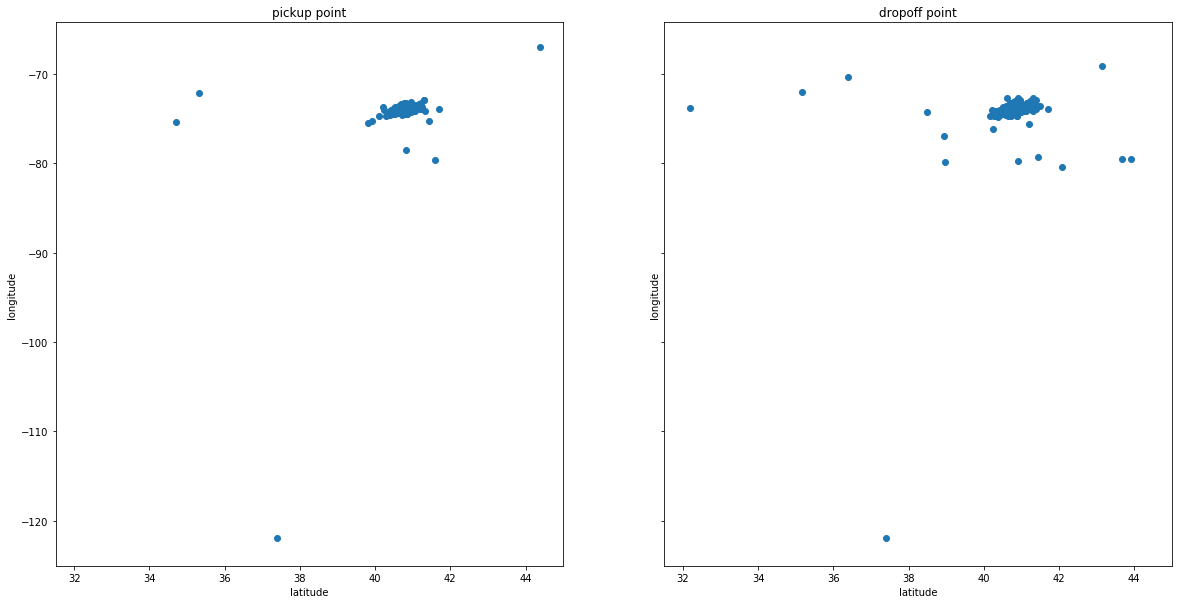

In [21]:
fig, ax = plt.subplots(1,2, figsize=(20, 10), sharex=True, sharey=True)
ax[0].set_title('pickup point')
ax[0].set_xlabel('latitude')
ax[0].set_ylabel('longitude')
ax[0].scatter(train.pickup_latitude, train.pickup_longitude, marker='o')
ax[1].set_title('dropoff point')
ax[1].set_xlabel('latitude')
ax[1].set_ylabel('longitude')
ax[1].scatter(train.dropoff_latitude, train.dropoff_longitude, marker='o')
plt.show()

In [ ]:
InteractiveShell.ast_node_interactivity = "all"

In [6]:
# pickup point outlier 
idx = train[(train.pickup_longitude == train.pickup_longitude.min()) | (train.pickup_latitude == train.pickup_latitude.max())].index
train = train.drop(idx)

In [ ]:
train.shape # (1458640, 12) -> (1458638, 12)

In [ ]:
InteractiveShell.ast_node_interactivity = "none"

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20, 10))
ax[0].set_title('pickup point')
ax[0].set_xlabel('latitude')
ax[0].set_ylabel('longitude')
ax[0].scatter(train.pickup_latitude, train.pickup_longitude, marker='o')
ax[1].set_title('dropoff point')
ax[1].set_xlabel('latitude')
ax[1].set_ylabel('longitude')
ax[1].scatter(train.dropoff_latitude, train.dropoff_longitude, marker='o')
plt.show()

In [ ]:
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
len(train) # 1458637
train.index.size

outlier 가져갈것인가?

In [ ]:
start = time.time()  # 시작 시간 저장

# total = tqdm_notebook(range(len(train))) # outlier 삭제로 전체 건수 loop 안됨 

fig, ax = plt.subplots(1,1, figsize=(20, 10))

for i in train.index: # total:
    plt.arrow(train.pickup_latitude[i], train.pickup_longitude[i]
            , (train.dropoff_latitude[i]-train.pickup_latitude[i])
            , (train.dropoff_longitude[i]-train.pickup_longitude[i]), head_width=0.01, head_length=0.01, fc='k', ec='k')
    
ax.set_title('start -> end arrow')
ax.set_xlim(32, 42)
ax.set_ylim(-90, -60)

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

In [ ]:
train['dist'].sort_values()

In [ ]:
train[train['dist'] == train['dist'].max()]

In [7]:
# 시간대비 거리가 너무 김 outlier 
idx = train[train['dist'] == train['dist'].max()].index
train = train.drop(idx)

In [ ]:
train.shape # (1458638, 12) -> (1458637, 12)

In [ ]:
start = time.time()  # 시작 시간 저장

# total = tqdm_notebook(range(len(train))) # outlier 삭제로 전체 건수 loop 안됨 

fig, ax = plt.subplots(1,1, figsize=(20, 10))

for i in train.index: # total:
    plt.arrow(train.pickup_latitude[i], train.pickup_longitude[i]
            , (train.dropoff_latitude[i]-train.pickup_latitude[i])
            , (train.dropoff_longitude[i]-train.pickup_longitude[i]), head_width=0.01, head_length=0.01, fc='k', ec='k')
    
ax.set_title('start -> end arrow')
ax.set_xlim(32, 42)
ax.set_ylim(-90, -60)

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

### 위도 경도로 거리 구하기 -> haversine

In [ ]:
train['dist'] = 0.0

start = time.time()  # 시작 시간 저장

total = tqdm_notebook(range(len(train)))

for i in total:
    train['dist'][i] = haversine((train.pickup_latitude[i], train.pickup_longitude[i]), (train.dropoff_latitude[i], train.dropoff_longitude[i]))
print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

In [ ]:
test['dist'] = 0.0

start = time.time()  # 시작 시간 저장

total = tqdm_notebook(range(len(test)))

for i in total:
    test['dist'][i] = haversine((test.pickup_latitude[i], test.pickup_longitude[i]), (test.dropoff_latitude[i], test.dropoff_longitude[i]))
print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

In [ ]:
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
train.head()
test.head()

### 시간: 픽업시간 (시간 -> 요일(평일/주말(공휴일)))

In [ ]:
InteractiveShell.ast_node_interactivity = "none"

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(20, 10))

# 날짜별 분포
ymd = train.pickup_datetime.dt.strftime('%Y-%m-%d').value_counts().sort_index()
ax[0].set_title('date hist')
ax[0].set_xlabel('date')
ax[0].set_ylabel('count')
ax[0].plot(ymd)

# 평일/주말 분포 # (0:월, 1:화, 2:수, 3:목, 4:금, 5:토, 6:일)
wk = train.pickup_datetime.dt.weekday.value_counts().sort_index()
ax[1].set_title('weekday hist')
ax[1].set_xlabel('weekday')
ax[1].set_ylabel('count')
ax[1].plot(wk)


# 시간별 분포 
hr = train.pickup_datetime.dt.strftime('%H').value_counts().sort_index()
ax[2].set_title('hour hist')
ax[2].set_xlabel('hour')
ax[2].set_ylabel('count')
ax[2].plot(hr)

plt.show()

In [ ]:
InteractiveShell.ast_node_interactivity = "all"

#### 1) date hist: 특정 날에 건수가 없는 날이 있음 제외 고려, 년/월/일/시 쪼개서 넣을것인가? 저 특이한 날은 제외하는게 학습에 도움이 되는가? 상관이 없는가? count 가 적으므로 dist 도 적어질테니까 없애는게 나을거 같은데... 
#### 2) weekday hist(0:월, 1:화, 2:수, 3:목, 4:금, 5:토, 6:일): 요일별 편차가 존재함
#### 3) hour hist: 새벽시간 건수가 적음 -> 시간별로 묶는 변수를 추가할까? 

In [ ]:
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(20, 10))

# 시간별 탑승 건수
datetimeCnt = train.pickup_datetime.dt.strftime('%Y-%m-%d %H').value_counts().sort_index()

ax.set_title('datetime - count')
ax.set_xlabel('datetime')
ax.set_ylabel('count')
ax.plot(datetimeCnt)

plt.show()

In [ ]:
# 거리 분포
train.dist.plot()

In [ ]:
train['dist'].groupby(train.pickup_datetime.dt.strftime('%Y-%m-%d')).sum()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(20, 10))

# 날자별 탑승 거리 
dateDist = train['dist'].groupby(train.pickup_datetime.dt.strftime('%Y-%m-%d')).sum()

ax.set_title('date - dist')
ax.set_xlabel('date')
ax.set_ylabel('dist')
ax.plot(dateDist)

plt.show()

In [ ]:
dateDist[dateDist == dateDist.min()]

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(20, 10))

# 날자별 탑승 거리 
dateDist_drop = train_drop['dist'].groupby(train_drop.pickup_datetime.dt.strftime('%Y-%m-%d')).sum()

ax.set_title('date - dist')
ax.set_xlabel('date')
ax.set_ylabel('dist')
ax.plot(dateDist_drop)

plt.show()

In [ ]:
dateDist_drop[dateDist_drop == dateDist_drop.min()]

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(20, 10))

# 날자별 탑승 거리 
dateDist_drop = train_drop['dist'].groupby(train_drop.pickup_datetime.dt.strftime('%Y-%m-%d')).sum()

ax.set_title('date - dist')
ax.set_xlabel('date')
ax.set_ylabel('dist')
ax.plot(dateDist_drop)

plt.show()

## 클러스터링
### 지역 클러스터: 경도/위도
-> 거리 
### 시간 클러스터: 픽업시간 시간 
-> 요일(평일/주말(공휴일)))

=> 클러스터링 결과로?
1) 클러스터로 묶어서 레코드를 추가할 수도 있고
2) 클러스터끼리 학습할 수도 있을것 같고

In [8]:
# Feature Extraction
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))

In [9]:
kmeans = MiniBatchKMeans(n_clusters=3, init='k-means++').fit(coords)

In [ ]:
kmeans

In [ ]:
pca = PCA().fit(coords)

In [ ]:
# Clustering
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

In [10]:
train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

In [ ]:
train['pickup_cluster'].value_counts()

In [23]:
pca = PCA().fit(coords)
train['pickup_pca0'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 0]
train['pickup_pca1'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 1]
train['dropoff_pca0'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
train['dropoff_pca1'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
test['pickup_pca0'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 0]
test['pickup_pca1'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 1]
test['dropoff_pca0'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
test['dropoff_pca1'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

In [22]:
InteractiveShell.ast_node_interactivity = "all"

In [11]:
# 년도는 동일, 월, 일, 시간, 요일 추출 
train['pickup_mm'] = train.pickup_datetime.dt.strftime('%m').astype('int')
train['pickup_dd'] = train.pickup_datetime.dt.strftime('%d').astype('int')
#train['pickup_date'] = train.pickup_datetime.dt.strftime('%m%d')
train['pickup_day'] = train['pickup_datetime'].dt.day
train['pickup_hour'] = train['pickup_datetime'].dt.hour
train['pickup_weekday'] = train.pickup_datetime.dt.weekday

test['pickup_mm'] = test.pickup_datetime.dt.strftime('%m').astype('int')
test['pickup_dd'] = test.pickup_datetime.dt.strftime('%d').astype('int')
#test['pickup_date'] = test.pickup_datetime.dt.strftime('%m%d')
test['pickup_day'] = test['pickup_datetime'].dt.day
test['pickup_hour'] = test['pickup_datetime'].dt.hour
test['pickup_weekday'] = test.pickup_datetime.dt.weekday

In [ ]:
train['pickup_week'] = train.pickup_datetime.dt.dayofweek
test['pickup_week'] = train.pickup_datetime.dt.dayofweek

## 인코딩

In [ ]:
train.columns

In [ ]:
train = pd.get_dummies(train, columns=['passenger_count'], prefix='passenger_count')
test = pd.get_dummies(test, columns=['passenger_count'], prefix='passenger_count')

In [12]:
train = pd.get_dummies(train, columns=['vendor_id'], prefix='vendor_id')
test = pd.get_dummies(test, columns=['vendor_id'], prefix='vendor_id')

In [ ]:
train = pd.get_dummies(train, columns=['pickup_weekday'], prefix='pickup_weekday')
test = pd.get_dummies(test, columns=['pickup_weekday'], prefix='pickup_weekday')

In [25]:
train = pd.get_dummies(train, columns=['store_and_fwd_flag'], prefix='store_and_fwd_flag')
test = pd.get_dummies(test, columns=['store_and_fwd_flag'], prefix='store_and_fwd_flag')

In [13]:
train['store_and_fwd_flag'] = 1 * (train.store_and_fwd_flag.values == 'Y')
test['store_and_fwd_flag'] = 1 * (test.store_and_fwd_flag.values == 'Y')

# 외부데이터

In [32]:
fr1 = pd.read_csv('new-york-city-taxi-with-osrm/fastest_routes_train_part_1.csv',
                  usecols=['id', 'total_distance', 'total_travel_time',  'number_of_steps'])
fr2 = pd.read_csv('new-york-city-taxi-with-osrm/fastest_routes_train_part_2.csv',
                  usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
test_street_info = pd.read_csv('new-york-city-taxi-with-osrm/fastest_routes_test.csv',
                               usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])

In [35]:
fr1
fr2
test_street_info

,id,total_distance,total_travel_time,number_of_steps
0,id2875421,2009.1,164.9,5
1,id2377394,2513.2,332.0,6
2,id3504673,1779.4,235.8,4
3,id2181028,1614.9,140.1,5
4,id0801584,1393.5,189.4,5
...,...,...,...,...
699995,id2460723,2724.2,265.8,5
699996,id2022803,4488.2,370.8,7
699997,id1091562,3529.0,281.1,3
699998,id3914165,2488.5,210.0,5


,id,total_distance,total_travel_time,number_of_steps
0,id0363241,2603.4,211.8,4
1,id1188175,1526.9,195.0,5
2,id3584231,2564.9,341.0,8
3,id3283815,3886.2,331.9,7
4,id0420326,1706.4,235.7,4
...,...,...,...,...
758638,id2976426,28051.1,1462.5,13
758639,id1440046,29616.3,1643.2,16
758640,id1607338,25615.0,1765.1,30
758641,id2071901,20284.1,1074.3,14


,id,total_distance,total_travel_time,number_of_steps
0,id0771704,1497.1,200.2,7
1,id3274209,1427.1,141.5,2
2,id2756455,2312.3,324.6,9
3,id3684027,931.8,84.2,4
4,id3101285,2501.7,294.7,8
...,...,...,...,...
625129,id3007749,8499.7,417.4,7
625130,id1674078,16688.7,890.4,11
625131,id2346166,15351.7,896.6,15
625132,id0689827,17591.6,1056.4,15


In [36]:
train_street_info = pd.concat((fr1, fr2))
train_street_info

,id,total_distance,total_travel_time,number_of_steps
0,id2875421,2009.1,164.9,5
1,id2377394,2513.2,332.0,6
2,id3504673,1779.4,235.8,4
3,id2181028,1614.9,140.1,5
4,id0801584,1393.5,189.4,5
...,...,...,...,...
758638,id2976426,28051.1,1462.5,13
758639,id1440046,29616.3,1643.2,16
758640,id1607338,25615.0,1765.1,30
758641,id2071901,20284.1,1074.3,14


In [37]:
train = train.merge(train_street_info, how='left', on='id')
test = test.merge(test_street_info, how='left', on='id')
train_street_info.head()

,id,total_distance,total_travel_time,number_of_steps
0,id2875421,2009.1,164.9,5
1,id2377394,2513.2,332.0,6
2,id3504673,1779.4,235.8,4
3,id2181028,1614.9,140.1,5
4,id0801584,1393.5,189.4,5


In [38]:
train
test

,id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist,...,vendor_id_2,pickup_pca0,pickup_pca1,dropoff_pca0,dropoff_pca1,store_and_fwd_flag_0,store_and_fwd_flag_1,total_distance,total_travel_time,number_of_steps
0,id2875421,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,455,1.498523,...,1,0.007553,-0.017068,-0.009785,-0.013613,1,0,2009.1,164.9,5.0
1,id2377394,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,663,1.805510,...,0,0.007703,0.012357,0.027205,0.018530,1,0,2513.2,332.0,6.0
2,id3858529,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,2124,6.385107,...,1,0.004688,-0.012877,0.034396,0.039175,1,0,11060.8,767.6,16.0
3,id3504673,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,429,1.485500,...,1,0.038460,0.029010,0.041533,0.042092,1,0,1779.4,235.8,4.0
4,id2181028,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,435,1.188590,...,1,-0.003152,-0.041704,-0.002595,-0.031029,1,0,1614.9,140.1,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1452735,id2376096,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,778,1.225082,...,1,0.009038,0.005298,0.022066,0.009824,1,0,2234.6,311.7,8.0
1452736,id1049543,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,655,6.049844,...,0,0.027625,0.002241,-0.006229,-0.044851,1,0,7638.0,589.6,11.0
1452737,id2304944,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,764,7.824617,...,1,-0.015480,-0.016450,0.033672,0.041944,1,0,9871.5,642.9,10.0
1452738,id2714485,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,373,1.092565,...,0,0.008689,0.001773,0.000741,-0.005777,1,0,1628.3,161.6,7.0


,id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,dist,pickup_cluster,dropoff_cluster,...,vendor_id_2,pickup_pca0,pickup_pca1,dropoff_pca0,dropoff_pca1,store_and_fwd_flag_0,store_and_fwd_flag_1,total_distance,total_travel_time,number_of_steps
0,id3004672,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,2.746430,1,1,...,0,0.015819,0.018383,0.016278,-0.006348,1,0,3795.9,424.6,4
1,id3505355,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,2.759243,1,1,...,0,-0.004717,0.071847,-0.007525,0.096668,1,0,2904.5,200.0,4
2,id1217141,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,1.306157,1,1,...,0,0.024752,0.012243,0.014016,0.021010,1,0,1499.5,193.2,4
3,id2150126,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,5.269095,0,1,...,1,-0.018732,-0.019349,0.014222,0.020049,1,0,7023.9,494.8,11
4,id1598245,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,0.960843,0,0,...,0,-0.003947,-0.009853,-0.012276,-0.003721,1,0,1108.2,103.2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625129,id3008929,2016-01-01 00:02:52,1,-74.003464,40.725105,-74.001251,40.733643,0.967439,1,1,...,0,0.031567,0.024308,0.028811,0.015930,1,0,1166.3,165.4,7
625130,id3700764,2016-01-01 00:01:52,1,-74.006363,40.743782,-73.953407,40.782467,6.196352,1,0,...,0,0.033262,0.005484,-0.022067,-0.029723,1,0,9572.1,676.1,10
625131,id2568735,2016-01-01 00:01:24,2,-73.972267,40.759865,-73.876602,40.748665,8.153730,0,0,...,0,-0.001796,-0.008378,-0.096545,0.008939,1,0,9492.3,687.0,13
625132,id1384355,2016-01-01 00:00:28,1,-73.976501,40.733562,-73.854263,40.891788,20.380776,1,0,...,0,0.004118,0.017599,-0.128023,-0.132456,1,0,23770.1,1295.1,21


In [55]:
train.isnull().sum()
test.isnull().sum().sum()

id                      0
pickup_datetime         0
dropoff_datetime        0
passenger_count         0
pickup_longitude        0
pickup_latitude         0
dropoff_longitude       0
dropoff_latitude        0
trip_duration           0
dist                    0
pickup_cluster          0
dropoff_cluster         0
pickup_mm               0
pickup_dd               0
pickup_day              0
pickup_hour             0
pickup_weekday          0
vendor_id_1             0
vendor_id_2             0
pickup_pca0             0
pickup_pca1             0
dropoff_pca0            0
dropoff_pca1            0
store_and_fwd_flag_0    0
store_and_fwd_flag_1    0
total_distance          0
total_travel_time       0
number_of_steps         0
dtype: int64

0

Int64Index([1128919], dtype='int64')

In [54]:
# 
idx = train[(train.total_distance.isnull()==True)].index

train = train.drop(idx)

## corr

In [ ]:
columns = [
           #'vendor_id'
           'vendor_id_1','vendor_id_2',
    
           'passenger_count'
    
           #, 'pickup_datetime'
           #,'pickup_date'
    
           ,'pickup_mm'
           ,'pickup_day','pickup_hour','pickup_weekday'
           ,'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'
           ,'dist'
           ,'store_and_fwd_flag'
           #,'store_and_fwd_flag_N','store_and_fwd_flag_Y'
            ,'trip_duration'
          ]
train_corr = train[columns]
train_corr.head()

In [ ]:
plt.figure(figsize=(14, 12))
sns.heatmap(train_corr.corr(), linewidths=0.1, vmax=1.0,
           square=True, cmap=plt.cm.RdBu, linecolor='white', annot=True, fmt='.3f', annot_kws={"size": 16})

# 3. 모델학습

In [14]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [ ]:
train.columns

In [39]:
test.columns

Index(['id', 'pickup_datetime', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'dist',
       'pickup_cluster', 'dropoff_cluster', 'pickup_mm', 'pickup_dd',
       'pickup_day', 'pickup_hour', 'pickup_weekday', 'vendor_id_1',
       'vendor_id_2', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0',
       'dropoff_pca1', 'store_and_fwd_flag_0', 'store_and_fwd_flag_1',
       'total_distance', 'total_travel_time', 'number_of_steps'],
      dtype='object')

In [56]:
#train.columns

columns = [
           #'vendor_id'
           'vendor_id_1','vendor_id_2',
    
           'passenger_count'
       #'passenger_count_0', 'passenger_count_1',
       #'passenger_count_2', 'passenger_count_3', 'passenger_count_4',
       #'passenger_count_5', 'passenger_count_6', 'passenger_count_7',
       #'passenger_count_8', 'passenger_count_9'
    
           #, 'pickup_datetime'
           #,'pickup_date'
    
           ,'pickup_mm'#,'pickup_dd'
           ,'pickup_day','pickup_hour'
           #,'pickup_week'
           ,'pickup_weekday'
           #,'pickup_weekday_0','pickup_weekday_1','pickup_weekday_2'
           #,'pickup_weekday_3','pickup_weekday_4','pickup_weekday_5','pickup_weekday_6'
           ,'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'
    
           ,'dist'
           
           #,'store_and_fwd_flag'
           ,'store_and_fwd_flag_0','store_and_fwd_flag_1'
           #,'store_and_fwd_flag_N','store_and_fwd_flag_Y'
    
           ,'pickup_cluster', 'dropoff_cluster'
    
          #, 'pickup_pca0', 'pickup_pca1','dropoff_pca0', 'dropoff_pca1'
    
          ,'total_distance', 'total_travel_time', 'number_of_steps'
          ]
X_train = train[columns]
#y_train = train['trip_duration']
y_train = np.log1p(train['trip_duration'])

X_test = test[columns]

In [ ]:
X_train.head()
X_train.info()  # 1458637 

In [57]:
rf_reg = RandomForestRegressor(n_jobs=-1)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [59]:
xgb_reg = XGBRegressor()
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [60]:
lgb_reg = LGBMRegressor()
lgb_reg.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

oneHot-store_and_fwd_flag-LinearRegression
oneHot-store_and_fwd_flag-RandomForestRegressor
oneHot-store_and_fwd_flag-XGBRegressor
oneHot-store_and_fwd_flag-LGBMRegressor

In [58]:
# RandomForestRegressor
y_pred_rf = rf_reg.predict(X_test)
#sample_submission['trip_duration'] = y_pred_rf
sample_submission['trip_duration'] = np.expm1(y_pred_rf)
sample_submission.to_csv('./output/20200824-4.csv', index=False)

In [ ]:
y_pred_rf = rf_reg.predict(X_test)

In [ ]:
y_pred_xgb = xgb_reg.predict(X_test)
y_pred_lgb = lgb_reg.predict(X_test)

In [ ]:
# soft voting 

# y_pred = (0.5*y_pred_xgb + 0.5*y_pred_lgb) # 0.41729
y_pred = (0.5*y_pred_rf + 0.3*y_pred_xgb + 0.2*y_pred_lgb) # 


sample_submission['trip_duration'] = np.expm1(y_pred)
sample_submission.to_csv('./output/20200824-5.csv', index=False)

In [62]:
# XGBRegressor
y_pred_xgb = xgb_reg.predict(X_test)
#sample_submission['trip_duration'] = y_pred_xgb
sample_submission['trip_duration'] = np.expm1(y_pred_xgb)
sample_submission.to_csv('./output/20200824-5.csv', index=False)

In [64]:
# LGBMRegressor
y_pred_lgb = lgb_reg.predict(X_test)
#sample_submission['trip_duration'] = y_pred_lgb
sample_submission['trip_duration'] = np.expm1(y_pred_lgb)
sample_submission.to_csv('./output/20200824-6.csv', index=False)

dayofweek - RandomForestRegressor

dayofweek - XGBRegressor
dayofweek - LGBMRegressor

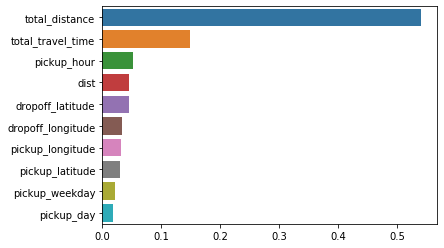

In [73]:
model = rf_reg 

frt_importances = pd.Series(model.feature_importances_, index=X_test.columns)

ftr_top = frt_importances.sort_values(ascending=False)[:10]

sns.barplot(x=ftr_top, y=ftr_top.index)

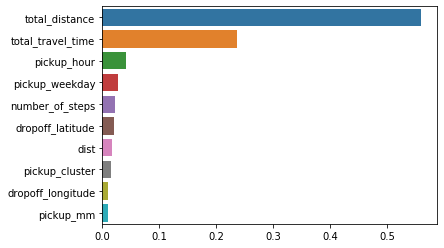

In [74]:
model = xgb_reg 

frt_importances = pd.Series(model.feature_importances_, index=X_test.columns)

ftr_top = frt_importances.sort_values(ascending=False)[:10]

sns.barplot(x=ftr_top, y=ftr_top.index)

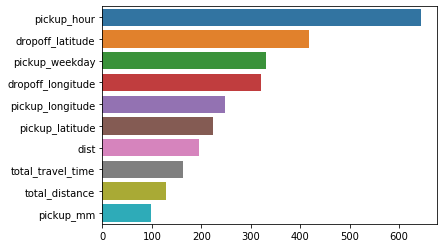

In [77]:
model = lgb_reg 

frt_importances = pd.Series(model.feature_importances_, index=X_test.columns)

ftr_top = frt_importances.sort_values(ascending=False)[:10]

sns.barplot(x=ftr_top, y=ftr_top.index)

In [78]:
import gc
gc.collect()

20